In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os

In [2]:
# MAKE CUSTOM FEATURES
from additional_features.make_features import make_all_features


In [3]:
from kaggle_submit import submit_to_kaggle
from helpers import *
from utils.globals import *
from utils.distribution_statistics import *
from objects import *

train_file = "kaggle_data/X_train.h5/X_train.h5"
test_file = "kaggle_data/X_test.h5/X_test.h5"

h5_train = h5py.File(train_file, mode='a')
h5_test = h5py.File(test_file, mode='a')

y_train = pd.read_csv("kaggle_data/y_train.csv", index_col=0, squeeze=True)
y_train_arr = y_train.to_numpy()

make_all_features(h5_train,h5_test,n_chunks=10, verbose=True, overwrite=False)

In [4]:
def ensure_integrity(h5_file):
    keys = list(h5_file.keys())
    for i, key in enumerate(keys):
        print_bis(f'{i+1}/{len(keys)}')
        x = h5_file[key][:]
        assert np.sum(np.isnan(x)) == 0
        assert np.sum(np.isinf(x)) == 0
        
# ensure_integrity(h5_train)
# ensure_integrity(h5_test)

In [5]:
"""
# SAVE MODEL

from joblib import dump, load
ARCHIVES_FOLDER = "models_archives"
if not os.path.exists(ARCHIVES_FOLDER):
    os.makedirs(ARCHIVES_FOLDER)

def save_model(model, name):
    fpath = os.path.join(ARCHIVES_FOLDER, f"{name}.joblib")
    dump(model, fpath)
    print(f"New model saved at {fpath}")
    return fpath
    
    
def load_model(name):
    if not name.startswith(ARCHIVES_FOLDER):
        name = os.path.join(ARCHIVES_FOLDER, name)
    if not name.endswith(".joblib"):
        name = f"{name}.joblib"
    model = load(name)
    return model

LEADERBOARD_FILE = "leaderboard.txt"
if not os.path.exists(LEADERBOARD_FILE):
    with open(LEADERBOARD_FILE, 'a') as leaderboard:
        leaderboard.write(";;;".join(['path', 'training_score', 'validation_score', 'comments']))
    
def write_model_to_leaderboard(model, model_name, train_score, val_score, comments=""):
    fpath = save_model(model, model_name)
    with open(LEADERBOARD_FILE, "a") as leaderboard:
        leaderboard.write("\n" + ';;;'.join([fpath, str(train_score), str(val_score), comments]))
    
"""
_ = ""

In [9]:
## Input maker

def make_input_for_svm_extreme(h5_file):
    return make_input(h5_file, features=FEATURES, quantiles=TAIL_QUANTILES, dist_char=False, truncate_dist=False)

svm_extreme_input_maker = InputMaker(make_input_for_svm_extreme)

## input shaper
import re
from sklearn.preprocessing import StandardScaler

pca_cols_filters = [
    lambda x: 'eeg' in x[0] and 'logmod' in x[0], 
    lambda x: bool(re.search('eeg_\d', x[0])),
]

pca_list = [CustomPCA(columns_filter=filt, name=f"PCA_{i}", var_capture=0.95) for i, filt in enumerate(pca_cols_filters)]

svm_extreme_input_shaper = InputShaper(*pca_list, StandardScaler())

## parameters grid
from sklearn.model_selection import ParameterGrid

svm_grid_1 = ParameterGrid({"kernel": ["rbf", "sigmoid"],
                            "C": [0.01, 0.1, 1, 10, 100],
                            "gamma": ["auto", "scale"]}
                          )
svm_grid_2 = ParameterGrid({"kernel": ["poly"],
                            "C": [0.01, 0.1, 1, 10, 100],
                            "degree": [1, 2, 3, 4]}
                          )
svm_hyperparameters = list(svm_grid_1) + list(svm_grid_2)


# generic object
from sklearn.svm import SVC

svm_extreme = PoolModels(
    input_maker=svm_extreme_input_maker,
    n_splits=5,
    train_size=27,
    input_shaper=svm_extreme_input_shaper,
    blueprint=SVC,
    parameters_list=svm_hyperparameters,
    warming_params={"max_iter":50},
    convergence_params={"max_iter": -1},
    seed=3,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr
)



In [ ]:
# train
import matplotlib.pyplot as plt
svm_extreme.warm_up()
svm_extreme.plot_validation()
plt.show()
best_svm_extremes = svm_extreme.train_n_best_models_until_convergence(3)

array([[0.30255735, 0.37209478, 0.32253286, 0.34858958, 0.35383957],
       [0.15295111, 0.17620489, 0.23907887, 0.15310042, 0.26138289],
       [0.30255735, 0.37209478, 0.32253286, 0.34858958, 0.35383957],
       [0.15295111, 0.17620489, 0.23907887, 0.15310042, 0.26138289],
       [0.61645923, 0.55135675, 0.32793672, 0.3713637 , 0.38782209],
       [0.2841427 , 0.19392094, 0.28523712, 0.19073815, 0.29461105],
       [0.31329486, 0.3684167 , 0.32793672, 0.3713637 , 0.38782209],
       [0.2841427 , 0.19392094, 0.28523712, 0.19073815, 0.29461105],
       [0.64757284, 0.58788906, 0.38668092, 0.38308121, 0.42455201],
       [0.41070686, 0.33956255, 0.35424458, 0.18455751, 0.30216606],
       [0.64757284, 0.58788906, 0.38668092, 0.38308121, 0.42455201],
       [0.41070686, 0.33956255, 0.35424458, 0.18455751, 0.30216606],
       [0.40529012, 0.25486341, 0.3832902 , 0.34051374, 0.26941998],
       [0.37836305, 0.26202003, 0.32650429, 0.23714689, 0.30339857],
       [0.40529012, 0.25486341, 0.

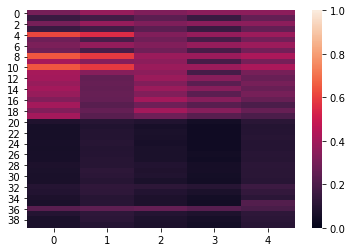

In [15]:
#svm_extreme.plot_validation()
svm_extreme.train_n_best_models_until_convergence(3, split_num=1)
svm_extreme.plot_validation()
svm_extreme.validation_scores

In [16]:
best_ix = svm_extreme.select_n_best_models(3)
svm_extreme.validation_scores[best_ix, :]

array([[0.61645923, 0.55135675, 0.32793672, 0.3713637 , 0.38782209],
       [0.64757284, 0.58788906, 0.38668092, 0.38308121, 0.42455201],
       [0.64757284, 0.58788906, 0.38668092, 0.38308121, 0.42455201]])

In [ ]:
#svm_extreme.train_on_all_data(svm_extreme.select_n_best_models(1)[0])

get_subject_ids(h5_train)

In [10]:
# SVM glouton


# input_maker

def make_input_glouton(h5_file):
    return make_input(h5_file, features=FEATURES, quantiles=QUANTILES, dist_char=True, truncate_dist=True)

glouton_im = InputMaker(make_input_glouton)

# input_shaper 
def make_filter(pat):
    def f(col_tup):
        return bool(re.search(pat, col_tup[0]))
    return f

groups_pats = ["alpha", "beta", "delta", "theta", "eeg_\d.*logmod"]
custom_pcas = [CustomPCA(make_filter(gp), name=gp, var_capture=0.95) for gp in groups_pats]
glouton_is = InputShaper(*custom_pcas, StandardScaler())

glouton_pool = PoolModels(
    input_maker=glouton_im,
    n_splits=5,
    train_size=27,
    input_shaper=glouton_is,
    blueprint=SVC,
    parameters_list=svm_hyperparameters,
    warming_params={"max_iter":50},
    convergence_params={"max_iter": -1},
    seed=3,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr
)

glouton_pool.warm_up()
glouton_pool.plot_validation()
plt.show()
best_gloutons = glouton_pool.train_n_best_models_until_convergence(1)

IndexError: index 4 is out of bounds for axis 1 with size 4

In [ ]:
for i in range(1,5):
    glouton_pool.train_n_best_models_until_convergence(1,split_num=i)
best_ix = glouton_pool.select_n_best_models(1)
glouton_pool.validation_scores[best_ix, :]


In [14]:
idx = glouton_pool.select_n_best_models(1)[0]
param = glouton_pool.parameters_list[idx]
model = SVC(**param)

X_train_shaped = glouton_pool.train_on_all_data(model)
glouton_pool.make_test_input()
pred = model.predict(glouton_pool.input_shaper.transform(glouton_pool.X_test))



TypeError: 'InputShaper' object is not callable

In [16]:
#pred = model.predict(glouton_pool.input_shaper.transform(glouton_pool.X_test))
#submit_to_kaggle(pred, h5_test, fname="submission_svm_glouton_28_12.csv", msg="svm")

New submission file at submissions/submission_svm_glouton_28_12.csv


In [ ]:
# RandomForest glouton

# input_maker

def make_input_glouton(h5_file):
    return make_input(h5_file, features=FEATURES, quantiles=QUANTILES, dist_char=True, truncate_dist=True)

glouton_im = InputMaker(make_input_glouton)

# input_shaper 
def make_filter(pat):
    def f(col_tup):
        return bool(re.search(pat, col_tup[0]))
    return f

groups_pats = ["alpha", "beta", "delta", "theta", "eeg_\d.*logmod"]
custom_pcas = [CustomPCA(make_filter(gp), name=gp, var_capture=0.95) for gp in groups_pats]
glouton_is = InputShaper(*custom_pcas, StandardScaler())

# Hyperparameters griabsd
random_forest_params = {
    "n_estimators": [10, 30, 100, 150],
    "max_depth": [3, 10, 30, 100],
    "min_samples_leaf": [1, 10, 100]}

rf_hyperparameters = list(ParameterGrid(random_forest_params))

from sklearn.ensemble import RandomForestClassifier

rf_glouton_pool = PoolModels(
    input_maker=glouton_im,
    n_splits=5,
    train_size=27,
    input_shaper=glouton_is,
    blueprint=RandomForestClassifier,
    parameters_list=rf_hyperparameters,
    warming_params={"max_iter":50},
    convergence_params={"max_iter": -1},
    convergence_params={},
    seed=3,
    h5_train=h5_train,
    h5_test=h5_test,
    y_train_arr=y_train_arr
)

rf_glouton_pool.warm_up()
rf_glouton_pool.plot_validation()
plt.show()
# rf_best_gloutons = rf_glouton_pool.train_n_best_models_until_convergence(5)

In [ ]:
d = {"a": "c"}
d.update({"n": "b"})

In [ ]:
d